In [1]:
from google.colab import drive
drive.mount('/content/drive/')

!git clone https://github.com/realcrane/iPLAN-Interactive-and-Procedural-Layout-Planning

import os
print("Directory di lavoro corrente:", os.getcwd())
roomType_directory = '/content/iPLAN-Interactive-and-Procedural-Layout-Planning/'
os.chdir(roomType_directory)
print("Nuova directory di lavoro:", os.getcwd())

Mounted at /content/drive/
Cloning into 'iPLAN-Interactive-and-Procedural-Layout-Planning'...
remote: Enumerating objects: 301, done.
remote: Counting objects: 100% (210/210), done.
remote: Compressing objects: 100% (156/156), done.
remote: Total 301 (delta 96), reused 106 (delta 46), pack-reused 91
Receiving objects: 100% (301/301), 12.98 MiB | 21.13 MiB/s, done.
Resolving deltas: 100% (117/117), done.
Directory di lavoro corrente: /content
Nuova directory di lavoro: /content/iPLAN-Interactive-and-Procedural-Layout-Planning


In [2]:
import numpy as np
import torch
from synth.floorplan.roomtype_fp import FloorPlan
from room_type import models
import scipy.io as sio

In [3]:
def getList(path):
  mat_list = os.listdir(path)
  mat_list.sort()
  temp_list = []
  for name in mat_list[:]: #Correzione
      mat_path = os.path.join(path, name)
      data = sio.loadmat(mat_path, squeeze_me=True, struct_as_record=False)['data']
      if type(data.rTypes) is not np.ndarray or len(data.rTypes) == 0:
          temp_list.append(name)

  return temp_list

In [4]:
max_room_per_type = [1, 2, 1, 2, 1, 1, 1, 3, 1, 3, 1, 1, 1]
max_room_num = np.sum(np.array(max_room_per_type))
noise_dim = 32
load_cvae_path = "/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/Progetto/Model/room_type/roomtype_cvae_150.pth"


# step1: configure model
print('Building model...')
cvae = models.cvae(
    modul_name='roomtype',
    model_name='cvae',
    input_dim=max_room_num,
    hidden_dim1=128,
    hidden_dim2=64,
    z_dim=noise_dim
)
print(cvae)

cvae.load_model(load_cvae_path)
cvae.cuda()

# step2: data

data_root = "/content/iPLAN-Interactive-and-Procedural-Layout-Planning/data/test"
floorplans = getList(data_root)

Input = []
Output = []
# step3: testing
for i in range(len(floorplans)):
  fp_name = floorplans[i]
  fp_path = os.path.join(data_root, fp_name)
  fp = FloorPlan(fp_path)

  # if given room types
  # fp.rTypes = fp.gt_rTypes
  # fp.rBoxes = np.array([])
  # fp.rCenters= np.array([])
  # data = fp.to_dict()
  # sio.savemat(fp_path, {'data': data})

  input_img = fp.init_input_img(fp.exterior_boundary)
  Input.append(input_img)
  input_img = torch.FloatTensor(input_img).unsqueeze(0).unsqueeze(0).cuda()
  input_img = fp.normalize(input_img)

  with torch.no_grad():
    emb = cvae.embed(input_img)
    z = torch.randn(input_img.size(0), 32).cuda()
    o_z = torch.cat([z, emb], 1)
    sample = cvae.decoder(o_z).cuda()
    sample = sample.view(-1, 19)
    fp.update_rTypes(sample.squeeze().cpu().numpy(), max_room_per_type)
    fp.rBoxes = np.array([])
    fp.rCenters = np.array([])
    data = fp.to_dict()
    Output.append(data)
    #sio.savemat(fp_path, {'data': data})

Building model...
CVAE(
  (fc1): Linear(in_features=83, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc31): Linear(in_features=64, out_features=32, bias=True)
  (fc32): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=96, out_features=96, bias=True)
  (fc5): Linear(in_features=96, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=19, bias=True)
  (relu): ReLU()
  (embed): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affi

In [5]:
import matplotlib.pyplot as plt
import numpy as np

plt.imsave('/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/Progetto/Input/mat0.png', Input[0], cmap='gray')
plt.imsave('/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/Progetto/Input/mat1.png', Input[1], cmap='gray')

In [5]:
room_label = [(0, 'LivingRoom'),
              (1, 'MasterRoom'),
              (2, 'Kitchen'),
              (3, 'Bathroom'),
              (4, 'DiningRoom'),
              (5, 'ChildRoom'),
              (6, 'StudyRoom'),
              (7, 'SecondRoom'),
              (8, 'GuestRoom'),
              (9, 'Balcony'),
              (10, 'Entrance'),
              (11, 'Storage'),
              (12, 'Wall-in'),
              (13, 'External'),
              (14, 'ExteriorWall'),
              (15, 'FrontDoor'),
              (16, 'Interior')]
grBoxes = []
Boundary = []
for dictionary in Output:
  for key, value in dictionary.items():
     if key == "gt_rBoxes": grBoxes.append(value)
     if key == "Boundary": Boundary.append(value)

In [35]:
for dictionary in Output:
  for key, value in dictionary.items():
    if key == "gt_rTypes": print("t", value)
    if key == "rTypes": print("r", value)

t [0 1 2 3 7 9]
r [0 1 2 3 7 9]
t [0 1 2 3 5 7 9]
r [0 1 2 3 7 9]


In [15]:
print(start_point)
print(end_point)
print(end_point[0] - start_point[0], end_point[1] - start_point[1])

(14, 55)
(101, 92)
87 37


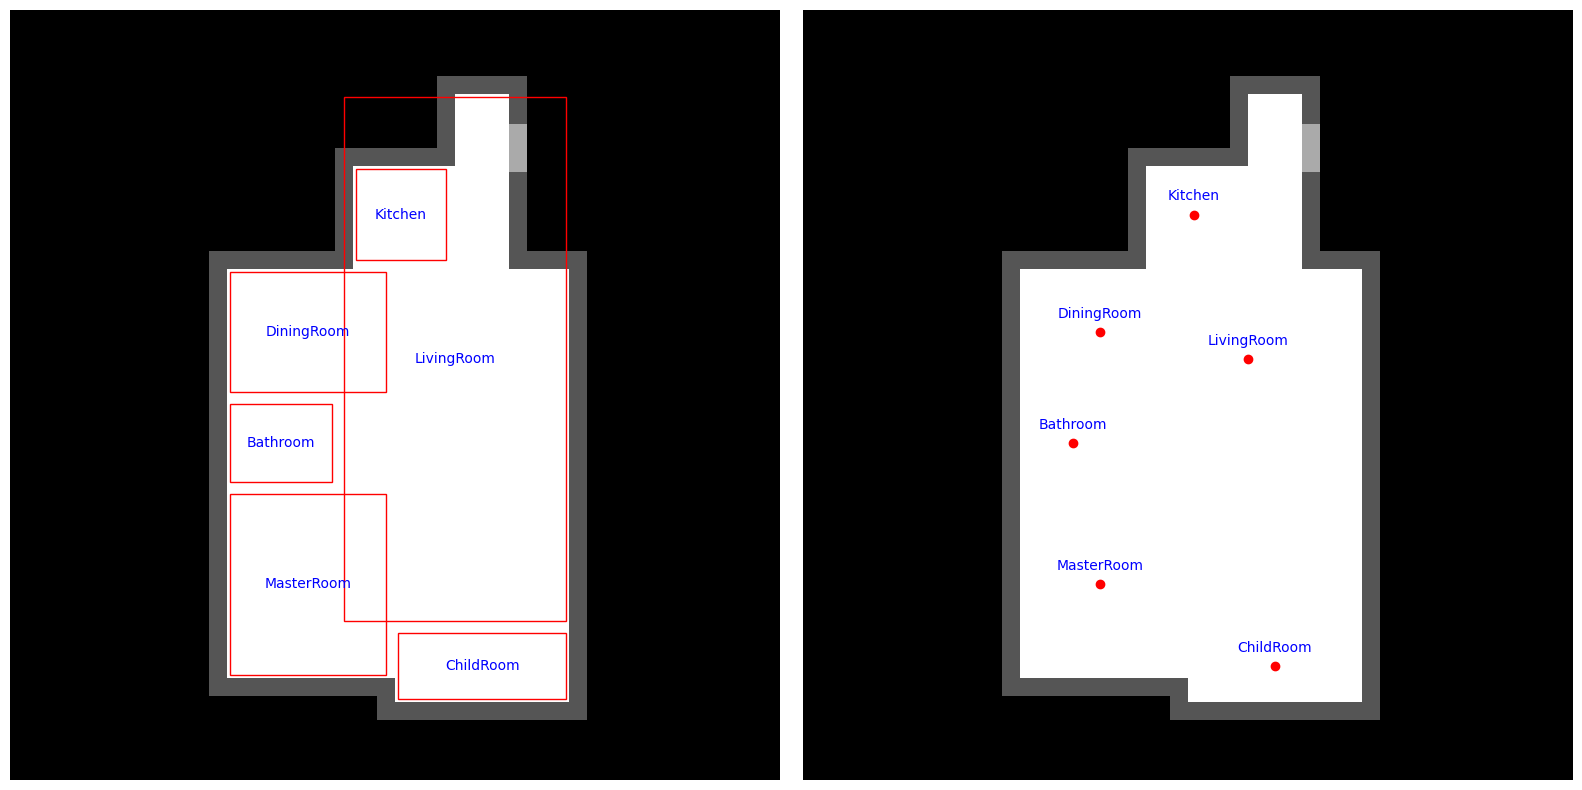

In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np



# Creare la griglia di subplot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Prima figura
ax = axes[0]
ax.imshow(Input[0], cmap='gray')
ax.grid("off")
ax.axis('off')
for j in range(len(grBoxes[0])):
    start_point = (grBoxes[0][j][1] , grBoxes[0][j][0])
    end_point = (grBoxes[0][j][3] ,grBoxes[0][j][2])
    rect = patches.Rectangle(start_point, end_point[0] - start_point[0], end_point[1] - start_point[1], linewidth=1, edgecolor='r', facecolor='none')
    ax.text(start_point[0] + (end_point[0] - start_point[0])/2, start_point[1] + (end_point[1] - start_point[1])/2, room_label[j][1], color='blue', ha='center', va='center')
    ax.add_patch(rect)


# Seconda figura
ax = axes[1]
ax.imshow(Input[0], cmap='gray')
ax.grid("off")
ax.axis('off')
for j in range(len(grBoxes[0])):
    start_point = (grBoxes[0][j][1] , grBoxes[0][j][0])
    end_point = (grBoxes[0][j][3] ,grBoxes[0][j][2])
    ax.scatter(start_point[0] + (end_point[0] - start_point[0])/2, start_point[1] + (end_point[1] - start_point[1])/2, color='red', marker='o')
    ax.text(start_point[0] + (end_point[0] - start_point[0])/2, start_point[1]-3 + (end_point[1] - start_point[1])/2, room_label[j][1], color='blue', ha='center', va='center')

# Regolare il layout
plt.tight_layout()
plt.show()

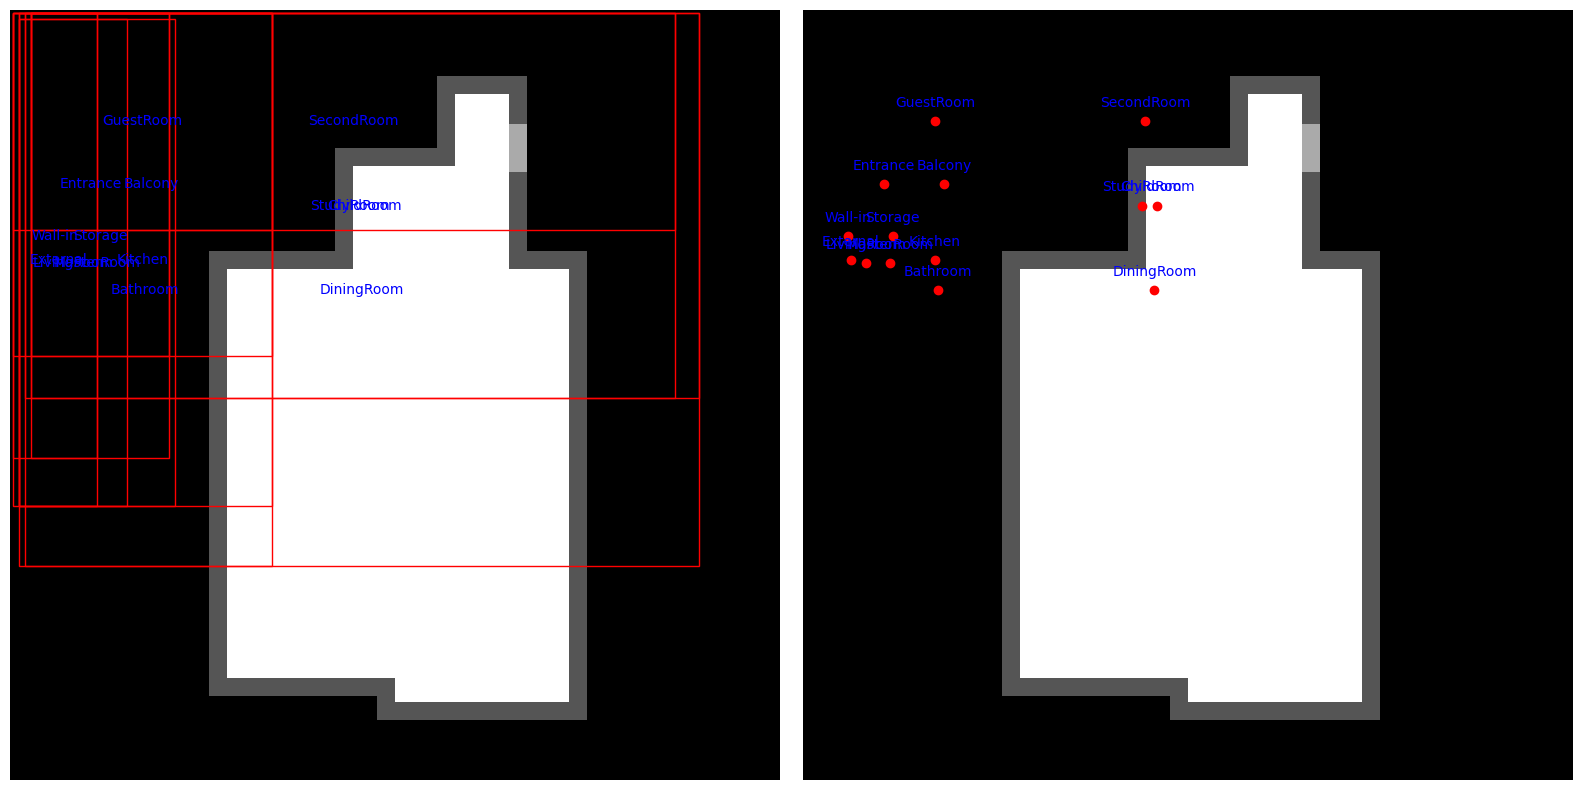

In [28]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np



# Creare la griglia di subplot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Prima figura
ax = axes[0]
ax.imshow(Input[0], cmap='gray')
ax.grid("off")
ax.axis('off')
for j in range(len(Boundary[0])):
    start_point = (Boundary[0][j][0], Boundary[0][j][1])
    end_point = (Boundary[0][j][2], Boundary[0][j][3])
    rect = patches.Rectangle(start_point, end_point[0] - start_point[0], end_point[1] - start_point[1], linewidth=1, edgecolor='r', facecolor='none')
    ax.text(start_point[0] + (end_point[0] - start_point[0])/2, start_point[1] + (end_point[1] - start_point[1])/2, room_label[j][1], color='blue', ha='center', va='center')
    ax.add_patch(rect)

# Seconda figura
ax = axes[1]
ax.imshow(Input[0], cmap='gray')
ax.grid("off")
ax.axis('off')
for j in range(len(Boundary[0])):
    start_point = (Boundary[0][j][0], Boundary[0][j][1])
    end_point = (Boundary[0][j][2], Boundary[0][j][3])
    ax.scatter(start_point[0] + (end_point[0] - start_point[0])/2, start_point[1] + (end_point[1] - start_point[1])/2, color='red', marker='o')
    ax.text(start_point[0] + (end_point[0] - start_point[0])/2, start_point[1]-3 + (end_point[1] - start_point[1])/2, room_label[j][1], color='blue', ha='center', va='center')

# Regolare il layout
plt.tight_layout()
plt.show()

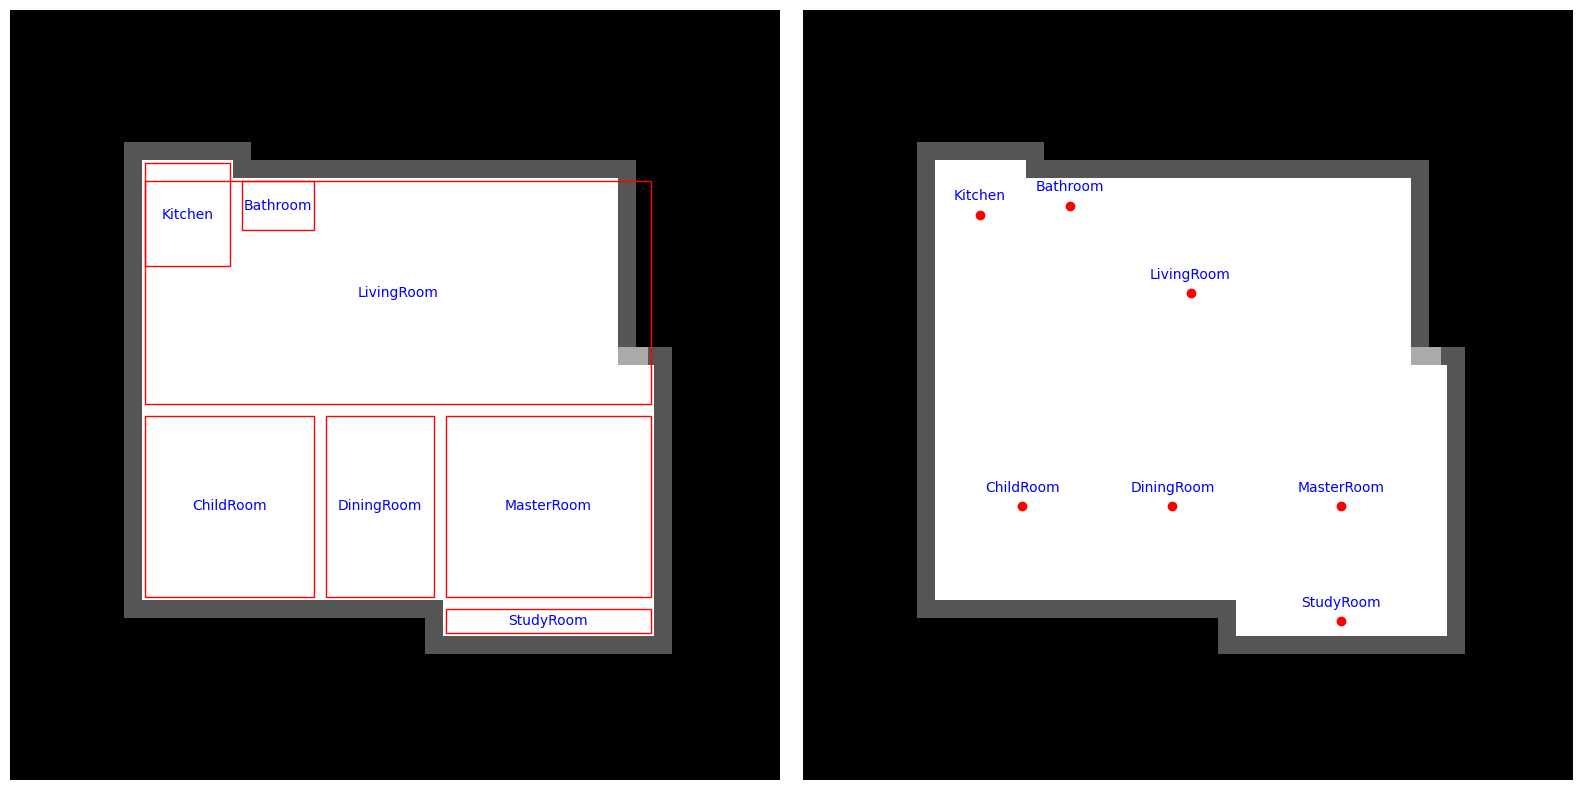

In [29]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np



# Creare la griglia di subplot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Prima figura
ax = axes[0]
ax.imshow(Input[1], cmap='gray')
ax.grid("off")
ax.axis('off')
for j in range(len(grBoxes[1])):
    start_point = (grBoxes[1][j][1], grBoxes[1][j][0])
    end_point = (grBoxes[1][j][3], grBoxes[1][j][2])
    rect = patches.Rectangle(start_point, end_point[0] - start_point[0], end_point[1] - start_point[1], linewidth=1, edgecolor='r', facecolor='none')
    ax.text(start_point[0] + (end_point[0] - start_point[0])/2, start_point[1] + (end_point[1] - start_point[1])/2, room_label[j][1], color='blue', ha='center', va='center')
    ax.add_patch(rect)

# Seconda figura
ax = axes[1]
ax.imshow(Input[1], cmap='gray')
ax.grid("off")
ax.axis('off')
for j in range(len(grBoxes[1])):
    start_point = (grBoxes[1][j][1], grBoxes[1][j][0])
    end_point = (grBoxes[1][j][3], grBoxes[1][j][2])
    ax.scatter(start_point[0] + (end_point[0] - start_point[0])/2, start_point[1] + (end_point[1] - start_point[1])/2, color='red', marker='o')
    ax.text(start_point[0] + (end_point[0] - start_point[0])/2, start_point[1]-3 + (end_point[1] - start_point[1])/2, room_label[j][1], color='blue', ha='center', va='center')

# Regolare il layout
plt.tight_layout()
plt.show()

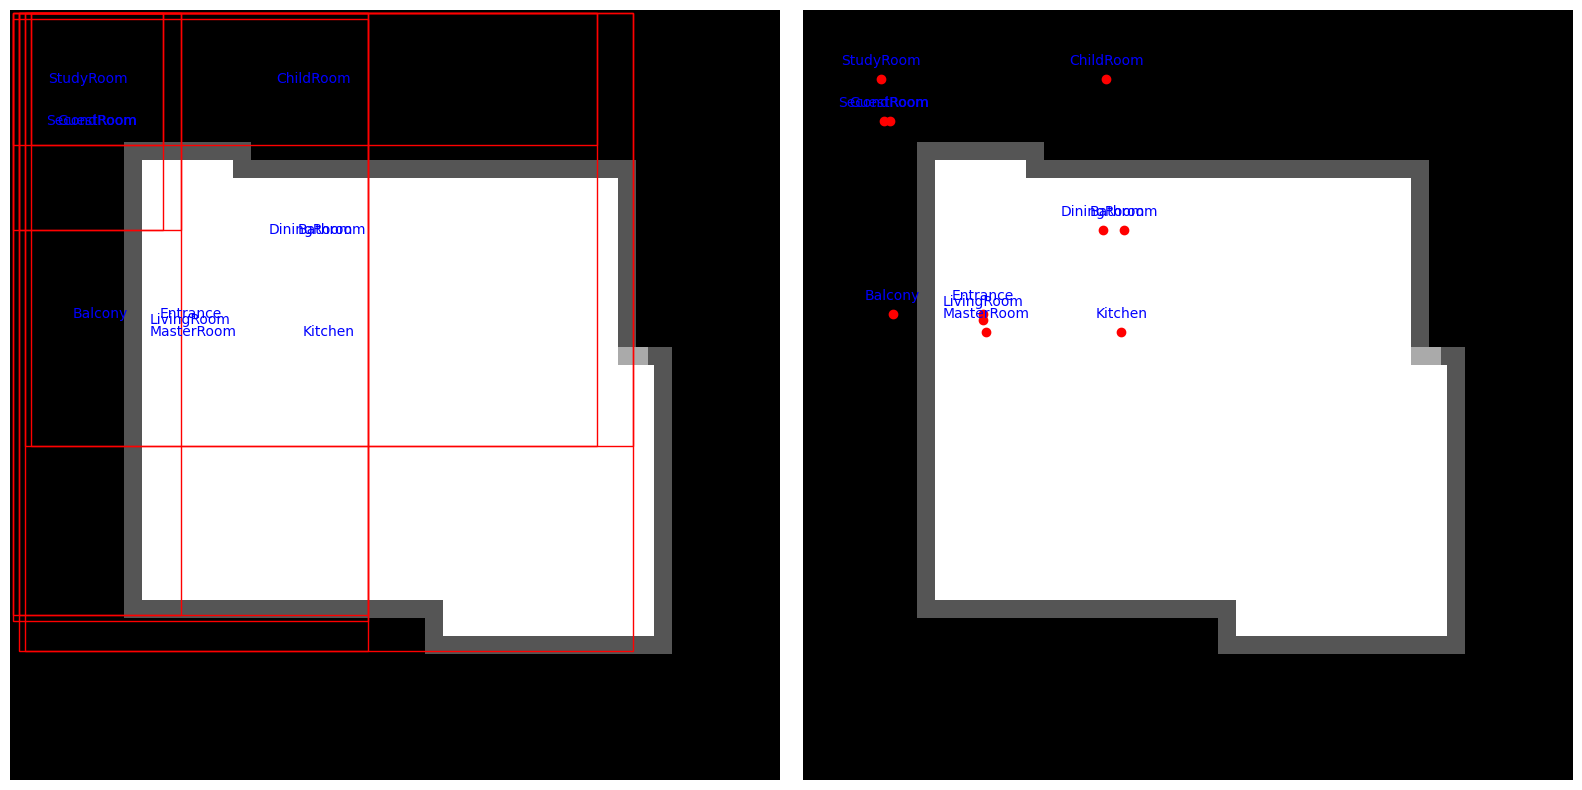

In [30]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np



# Creare la griglia di subplot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Prima figura
ax = axes[0]
ax.imshow(Input[1], cmap='gray')
ax.grid("off")
ax.axis('off')
for j in range(len(Boundary[1])):
    start_point = (Boundary[1][j][0], Boundary[1][j][1])
    end_point = (Boundary[1][j][2], Boundary[1][j][3])
    rect = patches.Rectangle(start_point, end_point[0] - start_point[0], end_point[1] - start_point[1], linewidth=1, edgecolor='r', facecolor='none')
    ax.text(start_point[0] + (end_point[0] - start_point[0])/2, start_point[1] + (end_point[1] - start_point[1])/2, room_label[j][1], color='blue', ha='center', va='center')
    ax.add_patch(rect)

# Seconda figura
ax = axes[1]
ax.imshow(Input[1], cmap='gray')
ax.grid("off")
ax.axis('off')
for j in range(len(Boundary[1])):
    start_point = (Boundary[1][j][0], Boundary[1][j][1])
    end_point = (Boundary[1][j][2], Boundary[1][j][3])
    ax.scatter(start_point[0] + (end_point[0] - start_point[0])/2, start_point[1] + (end_point[1] - start_point[1])/2, color='red', marker='o')
    ax.text(start_point[0] + (end_point[0] - start_point[0])/2, start_point[1]-3 + (end_point[1] - start_point[1])/2, room_label[j][1], color='blue', ha='center', va='center')

# Regolare il layout
plt.tight_layout()
plt.show()